In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Reshape
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout,MaxPooling1D
from tensorflow.keras.optimizers import Adam 
from keras.callbacks import LearningRateScheduler

import itertools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error

from tensorflow.keras.layers import BatchNormalization
import cv2
from tensorflow.keras.optimizers import Adam , Adadelta

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
train = pd.read_csv("../input/heartbeat/mitbih_train.csv" , header = None)
test = pd.read_csv("../input/heartbeat/mitbih_test.csv" , header = None)
display_test = pd.read_csv("../input/displayxai/display_XAI.csv" , header = None)

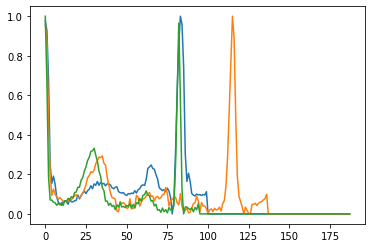

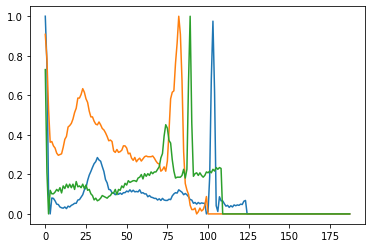

In [3]:
for i in range(3): plt.plot(train.iloc[i])
plt.show()
for i in range(3): plt.plot(test.iloc[i])
plt.show()

In [4]:
train.rename(columns={187:"Class"}, inplace=True)
test.rename(columns={187:"Class"}, inplace=True)
display_test.rename(columns={187:"Class"}, inplace=True)

In [5]:
train['Class'].unique()

array([0., 1., 2., 3., 4.])

In [6]:
test['Class'].unique()

array([0., 1., 2., 3., 4.])

In [7]:
mapping = {     0. : 'Normal Beat',
               1. : 'Supraventricular premature beat',
               2. : 'Premature ventricular contraction',
               3. : 'Fusion of ventricular',
               4. : 'Unclassifiable beat'}

In [8]:
train['label'] = train.iloc[:, -1].map(mapping)
test['label'] = test.iloc[:, -1].map(mapping)
display_test['label'] = display_test.iloc[:, -1].map(mapping)



In [9]:
from sklearn.utils import resample

df_1=train[train['Class']==1]
df_2=train[train['Class']==2]
df_3=train[train['Class']==3]
df_4=train[train['Class']==4]
df_0=(train[train['Class']==0]).sample(n=20000,random_state=42)



train=pd.concat([df_0,df_1,df_2,df_3,df_4])

In [10]:
X_train=train.iloc[:,:186].values
X_test=test.iloc[:,:186].values
X_display = display_test.iloc[: , :186].values

In [11]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(k_neighbors=1)
X_train, y_train = oversample.fit_resample(X_train, train["Class"])


In [12]:
from collections import Counter

counter = Counter(y_train)
print(counter)

Counter({0.0: 20000, 1.0: 20000, 2.0: 20000, 3.0: 20000, 4.0: 20000})


In [13]:
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
X_display = X_display.reshape(len(X_display), X_display.shape[1],1)

In [14]:
target_test=test["Class"]
target_display = display_test["Class"]

In [15]:
y_train= np.array(y_train).reshape(-1,1)
y_test= np.array(target_test).reshape(-1,1)
y_display = np.array(target_display).reshape(-1,1)

In [16]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
encoder_df1 = pd.DataFrame(enc.fit_transform(y_train).toarray())
encoder_df2 = pd.DataFrame(enc.fit_transform(y_test).toarray())
encoder_df4 = pd.DataFrame(enc.fit_transform(y_display).toarray())




In [17]:
y_train = np.array(encoder_df1)
y_test = np.array(encoder_df2)
y_display = np.array(encoder_df4)

In [18]:
from sklearn.model_selection import train_test_split
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [19]:
import tensorflow
X_train =tensorflow.convert_to_tensor(X_train, dtype=tensorflow.float32)
y_train = tensorflow.convert_to_tensor(y_train, dtype=tensorflow.float32)

X_test = tensorflow.convert_to_tensor(X_test, dtype=tensorflow.float32)
y_test = tensorflow.convert_to_tensor(y_test, dtype=tensorflow.float32)

X_validate = tensorflow.convert_to_tensor(X_validate, dtype=tensorflow.float32)
y_validate = tensorflow.convert_to_tensor(y_validate, dtype=tensorflow.float32)

X_display = tensorflow.convert_to_tensor(X_display, dtype=tensorflow.float32)
y_display = tensorflow.convert_to_tensor(y_display, dtype=tensorflow.float32)


2022-07-25 20:06:04.074423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 20:06:04.165853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 20:06:04.166780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 20:06:04.170792: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
X_train.shape

TensorShape([100000, 186, 1])

In [21]:
n_obs, feature, depth = X_train.shape
batch_size = 500

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout
from tensorflow.keras.optimizers import Adam


In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout

In [24]:



model = Sequential()

# Parameter 
filters=64
kernel_size=5
strides=3
activation="relu"
#learning_rate = trial.suggest_float("learning_rate", 0.1, 0.3)
epochs = 75
dense = 512
dropout = 0.4
pool_size=3
optimizer = "adam"
batch_size = 512





    #First CNN layer  with 32 filters, conv window 5, relu activation and same padding
model.add( 
    Conv1D (filters=filters,
                 kernel_size=kernel_size,
                 strides=strides,
                 padding='same',
                 activation=activation,
                 input_shape = (X_train.shape[1],1) ) )


#Second CNN layer  with 64 filters, conv window 5, relu activation and same padding
model.add(Conv1D(filters=filters,
                 kernel_size=kernel_size,
                 strides=strides,
                 padding='same',
                 activation=activation
                 ))

#Third CNN layer with 64 filters, conv window 5, relu activation and same padding
model.add(Conv1D(filters=filters,
                 kernel_size=kernel_size,
                 strides=strides,
                 padding='same',
                 activation=activation
                 ))


#Fourth CNN layer with Max pooling
model.add(MaxPool1D(pool_size=pool_size,
                    strides=strides,
                    padding='same'))


model.add(Dropout(dropout))
model.add(Flatten())
    #Add a dense layer with 512 neurons
model.add(Dense(units = dense , activation=activation))
model.add(BatchNormalization())

#Add a dense layer with 1024 neurons
model.add(Dense(units = dense , activation=activation))
model.add(BatchNormalization())
model.add(Dense(5, activation="softmax"))



In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 62, 64)            384       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 21, 64)            20544     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7, 64)             20544     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               9

In [26]:
# We compile our model with a sampled learning rate.


model.compile(
    loss="categorical_crossentropy",
    optimizer= optimizer,
    metrics=["accuracy"]
)

my_callbacks = [
        keras.callbacks.ModelCheckpoint(filepath='model_Cnn.h5' , monitor = 'val_loss' , save_best_only=True)
   ]



In [27]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_validate, y_validate), # Change X_tets , y_test >>> X_validate , y_Validate
    shuffle=True,
    batch_size=batch_size,
    epochs=epochs,
    verbose=True,
)

2022-07-25 20:06:06.921126: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/75


2022-07-25 20:06:08.544460: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


196/196 [==============================] - 11s 19ms/step - loss: 0.4612 - accuracy: 0.8316 - val_loss: 0.9552 - val_accuracy: 0.8621
Epoch 2/75
196/196 [==============================] - 4s 18ms/step - loss: 0.2388 - accuracy: 0.9128 - val_loss: 0.3938 - val_accuracy: 0.9447
Epoch 3/75
196/196 [==============================] - 4s 19ms/step - loss: 0.1851 - accuracy: 0.9331 - val_loss: 0.1696 - val_accuracy: 0.9651
Epoch 4/75
196/196 [==============================] - 4s 18ms/step - loss: 0.1572 - accuracy: 0.9439 - val_loss: 0.1930 - val_accuracy: 0.9370
Epoch 5/75
196/196 [==============================] - 4s 19ms/step - loss: 0.1383 - accuracy: 0.9500 - val_loss: 0.3005 - val_accuracy: 0.8955
Epoch 6/75
196/196 [==============================] - 4s 19ms/step - loss: 0.1200 - accuracy: 0.9571 - val_loss: 0.2096 - val_accuracy: 0.9293
Epoch 7/75
196/196 [==============================] - 4s 18ms/step - loss: 0.1130 - accuracy: 0.9601 - val_loss: 0.1698 - val_accuracy: 0.9397
Epoch 8/7

In [28]:
model.save("model_Cnn.h5")

In [29]:
y_pred = model.predict(X_test, batch_size=1000)

In [30]:
y_pred=np.argmax(y_pred, axis=1)
yyy_test = np.argmax(y_test , axis = 1)

In [31]:
print("Model Accuracy is : " , accuracy_score(yyy_test, y_pred) )

Model Accuracy is :  0.9795359035264023


In [32]:
print(classification_report(yyy_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9012
           1       0.81      0.83      0.82       289
           2       0.94      0.96      0.95       754
           3       0.64      0.88      0.74        78
           4       0.98      0.99      0.98       813

    accuracy                           0.98     10946
   macro avg       0.87      0.93      0.90     10946
weighted avg       0.98      0.98      0.98     10946



In [33]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)


Evaluate on test data
86/86 [==============================] - 0s 3ms/step - loss: 0.1053 - accuracy: 0.9795
test loss, test acc: [0.10533678531646729, 0.9795358777046204]


Text(0, 0.5, 'Loss')

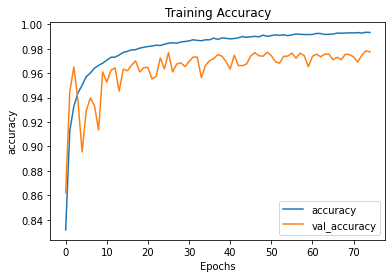

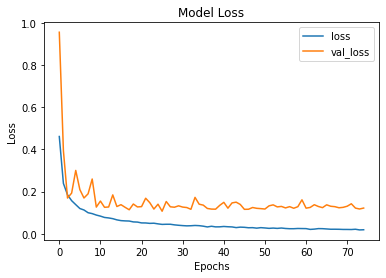

In [34]:
# converting hsitory to dataframe
pd.DataFrame(history.history)

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion matrix, without normalization


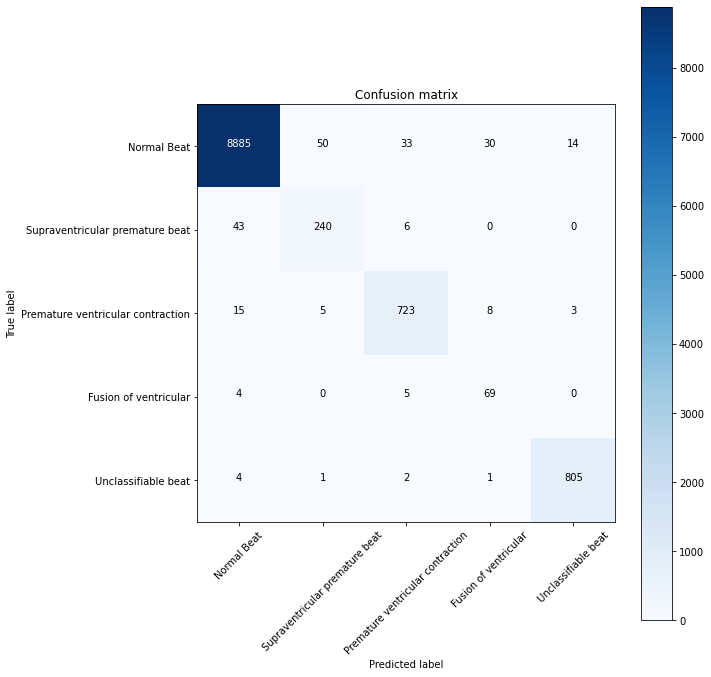

In [36]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(yyy_test, y_pred)


# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['Normal Beat', 'Supraventricular premature beat',
       'Premature ventricular contraction', 'Fusion of ventricular',
       'Unclassifiable beat'],
                      title='Confusion matrix')
plt.show()

In [37]:
from sklearn import metrics
import itertools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 


In [38]:
fpr, tpr, thresholds = metrics.roc_curve(yyy_test, y_pred, pos_label=2)

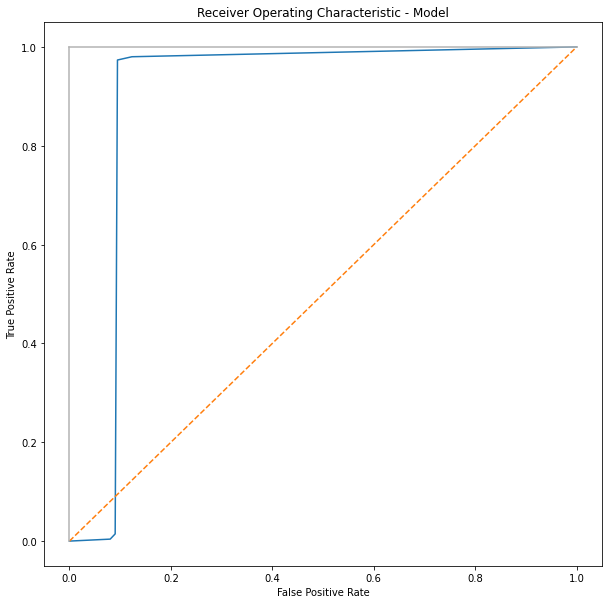

In [39]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Model')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [40]:
auc = metrics.auc(fpr, tpr)
print("Auc is : ")
print(auc )


Auc is : 
0.8984147602113687


In [41]:
import tensorflow.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
#tf.compat.v1.reset_default_graph()


run_eagerly = True



def gradcam(model, x, index, layer_name):
   
    #with tf.Graph().as_default():
    model = tf.keras.models.load_model('./model_Cnn.h5')
    preds = model.predict(x)
    #model._make_predict_function()
    pred_class = np.argmax(preds[index])
    
    
    #pred_class_name = imagenet_utils.decode_predictions(preds)[0][0][1]
    
   
    pred_output = model.output[:, pred_class]
    
   
    # convolution layer
    last_conv_layer = model.get_layer(layer_name)
    
    #  convolution layer 
    grads = K.gradients(pred_output, last_conv_layer.output)[0]
    
    # feature map 
    #pooled_grads = K.sum(grads, axis=(0, 1, 2))
    pooled_grads = K.sum(grads, axis=(0, 1))
    
    # K.function()  `model.input` `pooled_grads` 
    # `last_conv_layer[0]` Tensorflow feed_dict
    
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[index]])
    
    #  x，feature map convolution layer 
    # feature map
    pooled_grads_value, conv_layer_output_value = iterate([x])
    
    # 將 feature map
    for i in range(pooled_grads_value.shape[0]):
        conv_layer_output_value[:, i] *= (pooled_grads_value[i])
        
    # feature map channel-wise 
    heatmap = np.sum(conv_layer_output_value, axis=-1)
    
    return heatmap, pred_class

In [42]:
def heatmap_():
    heatmap_2d = np.expand_dims(heatmap,1)
    heatmap_2d = cv2.resize(heatmap_2d, (100,188))

    figure = plt.figure(figsize=(80,4))
    ax = figure.add_subplot(111)
    x = np.arange(0, 188, 1)
    ax.plot(x, data*100)
    ax.imshow(np.transpose(heatmap_2d), cmap="Oranges", extent=[0, 188, -10, 120])
    ax.autoscale(False)
    ax.set_xlim(0, 187)
    ax.set_ylim(-10, 110)
    ax.set_title(title)
    plt.show()

In [43]:
def heatmap_3x():
    def preprocess_heatmap(heatmap):
        heatmap_2d = np.expand_dims(heatmap,1)
        heatmap_2d = cv2.resize(heatmap_2d, (100,186))
        heatmap_2d = np.transpose(heatmap_2d)
        return heatmap_2d

    fig, ax = plt.subplots(1,len(name_list)+1,figsize=(20,4))
    x = np.arange(0, 186, 1)
    Collect_attention = list()
    for i in range(1,len(name_list)+1):
        ax[i].plot(x, data*100)
        heatmap_2d = preprocess_heatmap(Collect_heatmap[i-1])
        Collect_attention.append(heatmap_2d[0])
        ax[i].imshow(heatmap_2d, cmap="Oranges", extent=[0, 186, -10, 120])
        ax[i].set_xlim(0, 187)
        ax[i].set_ylim(-10, 110)
        ax[i].set_title(name_list[i-1])
    ax[0].plot(x, data, label="ECG")
    for i in range(len(name_list)):
        ax[0].set_title(title)
        ax[0].plot(x, Collect_attention[i]/np.max(Collect_attention[i]), label=name_list[i])
        ax[0].set_ylim(-0.2, 1)
    ax[0].legend()

    plt.show()

In [44]:
X_display = np.array(X_display).astype(float)

In [45]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
y_display = y_display.tolist()

In [46]:
from tensorflow import keras
model_layer = keras.models.load_model('./model_Cnn.h5')

2022-07-25 20:10:47.238702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 20:10:47.239511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 20:10:47.240044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 20:10:47.240572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 20:10:47.241020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [47]:
for i, layer in enumerate(model_layer.layers):
    print(i, layer.name, layer.output_shape)

0 conv1d (None, 62, 64)
1 conv1d_1 (None, 21, 64)
2 conv1d_2 (None, 7, 64)
3 max_pooling1d (None, 3, 64)
4 dropout (None, 3, 64)
5 flatten (None, 192)
6 dense (None, 512)
7 batch_normalization (None, 512)
8 dense_1 (None, 512)
9 batch_normalization_1 (None, 512)
10 dense_2 (None, 5)


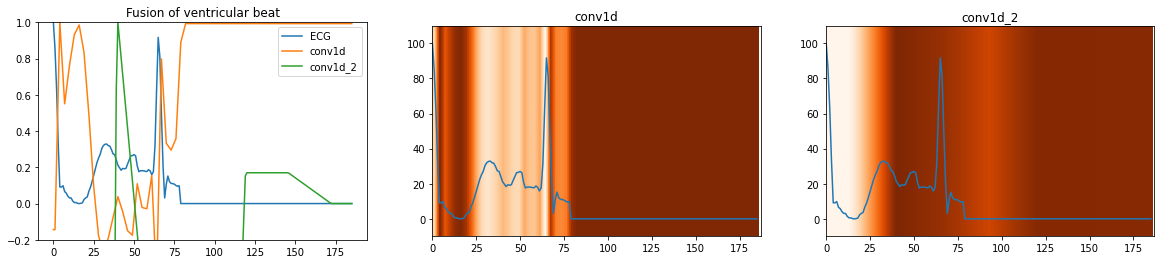

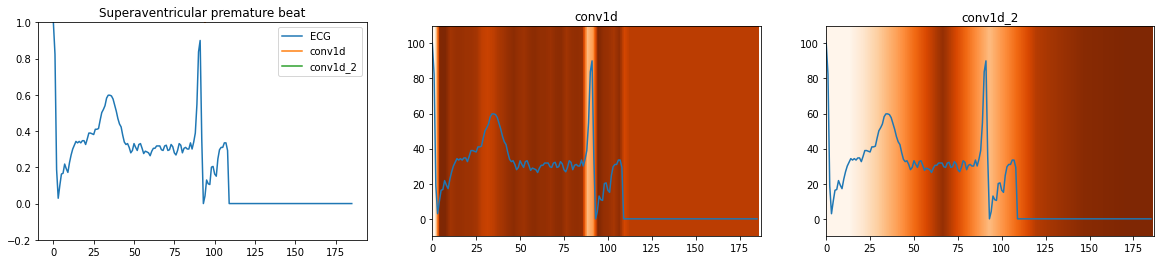

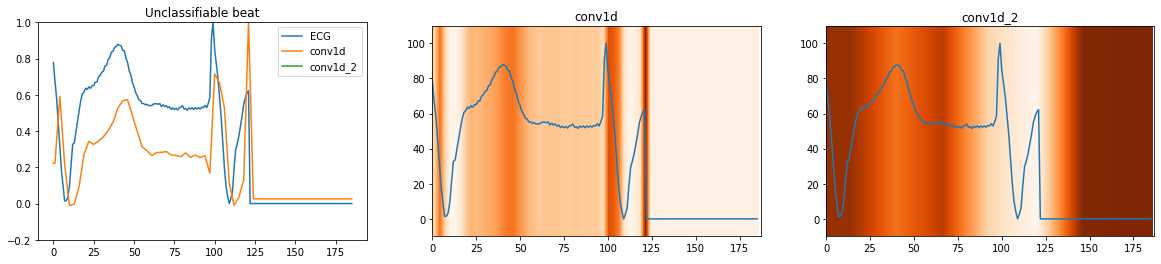

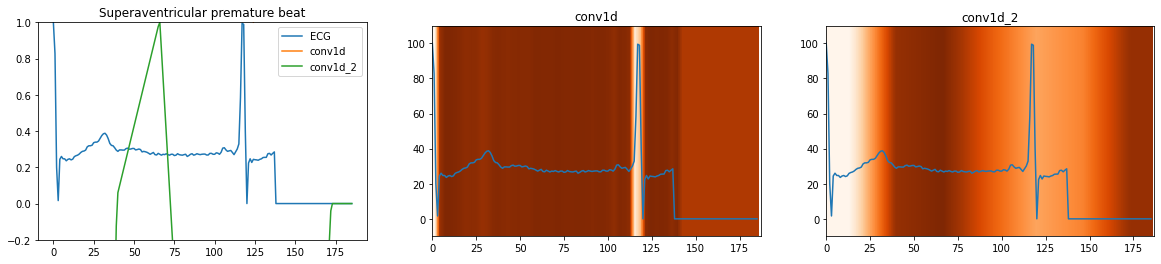

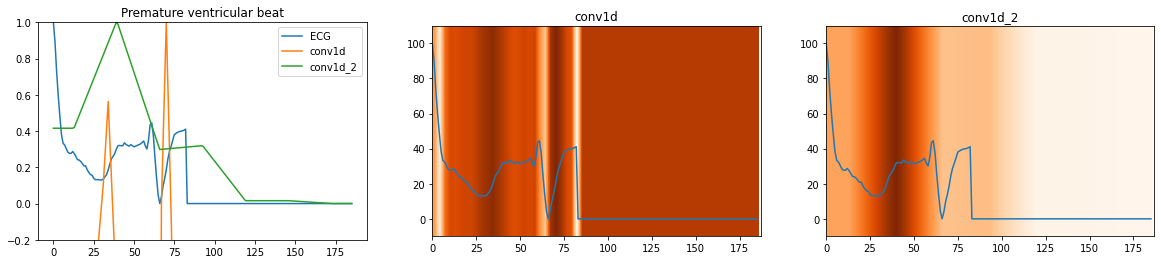

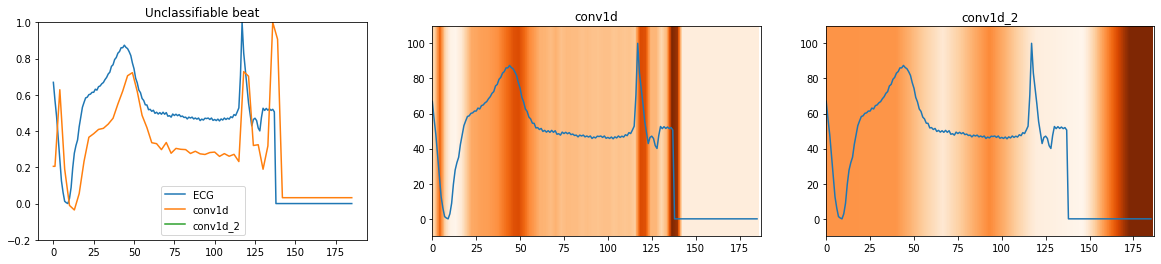

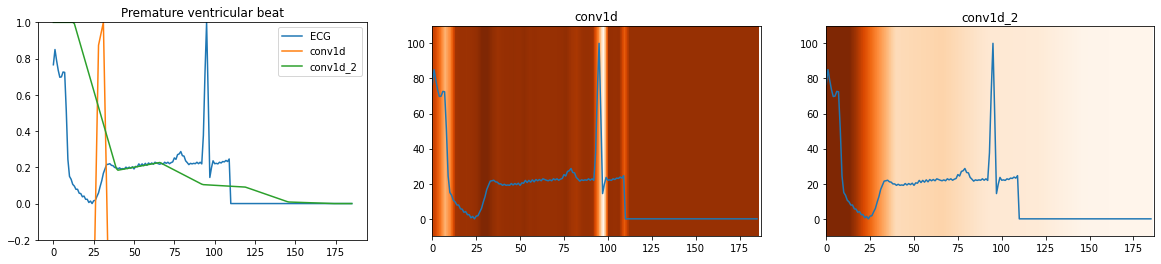

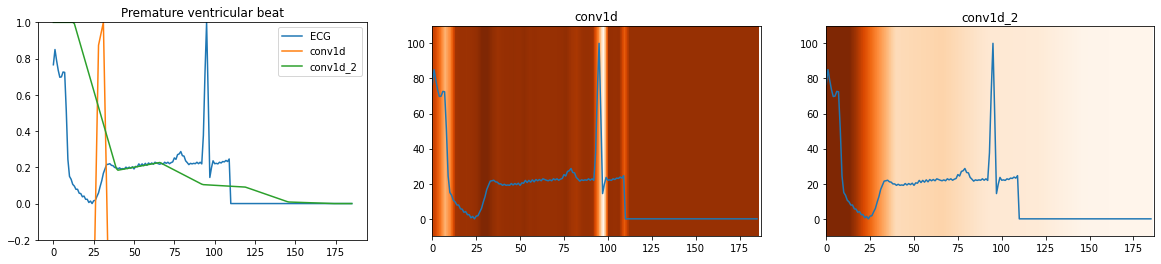

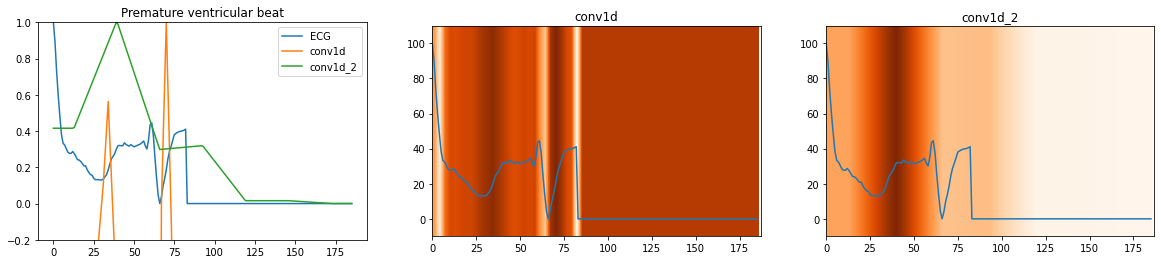

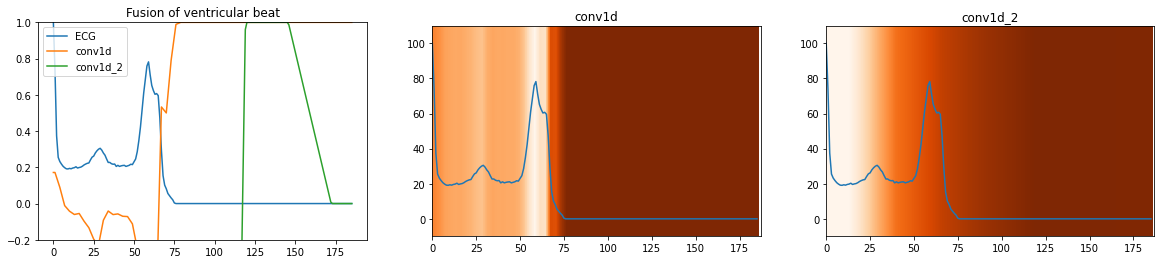

In [48]:
for i in range(10):
    Collect_heatmap = list()
    index = np.random.randint(0,len(X_display))
    name_list = ["conv1d" ,"conv1d_2"]
    for name in name_list:
        heatmap, pred_class = gradcam(model, X_display, index, name)
        Collect_heatmap.append(heatmap)
    data = X_display[index]
    
    if int(y_display[index][0]==1): 
        title = "Normal"
    elif int(y_display[index][1]==1):
        title = "Superaventricular premature beat"
    elif int(y_display[index][2]==1):
        title = "Premature ventricular beat"
    elif int(y_display[index][3]==1):
        title = "Fusion of ventricular beat"
    elif int(y_display[index][4]==1):
        title = "Unclassifiable beat"
   
   
    heatmap_3x()